In [22]:
import pandas as pd
from sklearn import preprocessing
from sklearn.model_selection  import train_test_split
from sklearn import tree
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import pickle
pd.set_option('display.max_columns', 500)

In [2]:
data = pd.read_csv('data/PS_20174392719_1491204439457_log.csv')

In [3]:
data.drop(['isFlaggedFraud'], axis=1, inplace=True)

In [4]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0


It would be helpful if this data had the timestamp when the transaction took place. This would help in determining the transaction time pattern per account.

The below column reference:

1. step: represents a unit of time where 1 step equals 1 hour
2. type: type of online transaction
3. amount: the amount of the transaction
4. nameOrig: customer starting the transaction
5. oldbalanceOrg: balance before the transaction
6. newbalanceOrig: balance after the transaction
7. nameDest: recipient of the transaction
8. oldbalanceDest: initial balance of recipient before the transaction
9. newbalanceDest: the new balance of recipient after the transaction
10. isFraud: fraud transaction

In [5]:
data.isna().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
dtype: int64

In [6]:
data.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

## Feature engineering

In [7]:
name_type_amount_grp_df = data.groupby(['nameOrig', 'type'])['amount'].agg(['mean', 'min', 'max', 'count']).reset_index()

In [8]:
name_type_amount_grp_df.head()

,nameOrig,type,mean,min,max,count
0,C1000000639,CASH_OUT,244486.46,244486.46,244486.46,1
1,C1000001337,PAYMENT,3170.28,3170.28,3170.28,1
2,C1000001725,PAYMENT,8424.74,8424.74,8424.74,1
3,C1000002591,CASH_IN,261877.19,261877.19,261877.19,1
4,C1000003372,CASH_IN,20528.65,20528.65,20528.65,1


In [9]:
for ag in ['mean', 'min', 'max', 'count']:
    name_type_agg_grp_df = name_type_amount_grp_df.pivot(columns='type', index='nameOrig', values=ag).reset_index().fillna(0)
    name_type_agg_columns = name_type_agg_grp_df.columns
    name_type_agg_columns = ['nameOrig']+[col.lower()+f'_{ag}' for col in name_type_agg_columns if col!='nameOrig']
    name_type_agg_grp_df.columns = name_type_agg_columns
    data = data.merge(name_type_agg_grp_df, on='nameOrig', how='left')

In [10]:
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,cash_in_mean,cash_out_mean,debit_mean,payment_mean,transfer_mean,cash_in_min,cash_out_min,debit_min,payment_min,transfer_min,cash_in_max,cash_out_max,debit_max,payment_max,transfer_max,cash_in_count,cash_out_count,debit_count,payment_count,transfer_count
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0.0,0.0,0.0,9839.64,0.0,0.0,0.0,0.0,9839.64,0.0,0.0,0.0,0.0,9839.64,0.0,0.0,0.0,0.0,1.0,0.0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0.0,0.0,0.0,1864.28,0.0,0.0,0.0,0.0,1864.28,0.0,0.0,0.0,0.0,1864.28,0.0,0.0,0.0,0.0,1.0,0.0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0.0,0.0,0.0,0.00,181.0,0.0,0.0,0.0,0.00,181.0,0.0,0.0,0.0,0.00,181.0,0.0,0.0,0.0,0.0,1.0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0.0,181.0,0.0,0.00,0.0,0.0,181.0,0.0,0.00,0.0,0.0,181.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0.0,0.0,0.0,11668.14,0.0,0.0,0.0,0.0,11668.14,0.0,0.0,0.0,0.0,11668.14,0.0,0.0,0.0,0.0,1.0,0.0


In [11]:
le = preprocessing.LabelEncoder()
le.fit(data['type'])

LabelEncoder()

In [12]:
data['transformed_type'] = le.transform(data['type'])

In [13]:
data.drop(['nameOrig', 'nameDest', 'type', 'step'], axis=1, inplace=True)
data.shape

(6362620, 27)

In [14]:
data.head()

,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,cash_in_mean,cash_out_mean,debit_mean,payment_mean,transfer_mean,cash_in_min,cash_out_min,debit_min,payment_min,transfer_min,cash_in_max,cash_out_max,debit_max,payment_max,transfer_max,cash_in_count,cash_out_count,debit_count,payment_count,transfer_count,transformed_type
0,9839.64,170136.0,160296.36,0.0,0.0,0,0.0,0.0,0.0,9839.64,0.0,0.0,0.0,0.0,9839.64,0.0,0.0,0.0,0.0,9839.64,0.0,0.0,0.0,0.0,1.0,0.0,3
1,1864.28,21249.0,19384.72,0.0,0.0,0,0.0,0.0,0.0,1864.28,0.0,0.0,0.0,0.0,1864.28,0.0,0.0,0.0,0.0,1864.28,0.0,0.0,0.0,0.0,1.0,0.0,3
2,181.00,181.0,0.00,0.0,0.0,1,0.0,0.0,0.0,0.00,181.0,0.0,0.0,0.0,0.00,181.0,0.0,0.0,0.0,0.00,181.0,0.0,0.0,0.0,0.0,1.0,4
3,181.00,181.0,0.00,21182.0,0.0,1,0.0,181.0,0.0,0.00,0.0,0.0,181.0,0.0,0.00,0.0,0.0,181.0,0.0,0.00,0.0,0.0,1.0,0.0,0.0,0.0,1
4,11668.14,41554.0,29885.86,0.0,0.0,0,0.0,0.0,0.0,11668.14,0.0,0.0,0.0,0.0,11668.14,0.0,0.0,0.0,0.0,11668.14,0.0,0.0,0.0,0.0,1.0,0.0,3


In [15]:
X = data.drop('isFraud', axis=1)
y = data['isFraud']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## baseline model

## decision tree

In [16]:
clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train, y_train)

In [17]:
accuracy_score(clf.predict(X_test), y_test)

0.9997242417242751

In [18]:
f1_score(clf.predict(X_test), y_test)

0.8910630291627469

In [19]:
precision_score(clf.predict(X_test), y_test)

0.8882220555138785

In [20]:
recall_score(clf.predict(X_test), y_test)

0.893922234805587

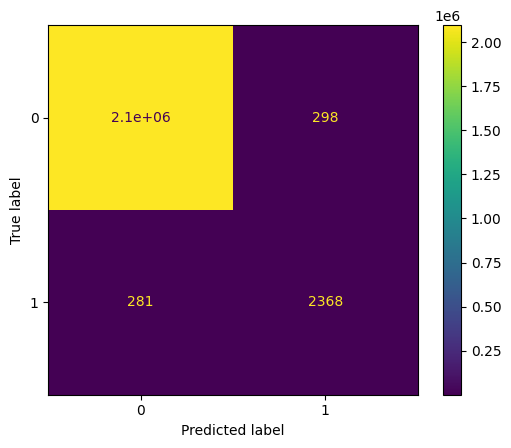

In [21]:
cm = confusion_matrix(clf.predict(X_test), y_test)
disp = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = clf.classes_)
disp.plot()
plt.show();

In [28]:
filehandler = open(b"models/decision_trees_1.pkl","wb")
pickle.dump(clf, filehandler)